<a href="https://colab.research.google.com/github/Gooogr/Brain2Image/blob/master/sub_notebooks/EEG_classificator_custom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

EEG signals classificator based on Perceive Lab dataset<br>
Dataset:  http://www.perceivelab.com/dataset/EEG%20Data%20for%20Visual%20Classification

In [1]:
# Imports
import sys
import os
import random
import math
import matplotlib.pyplot as plt
import time
import torch; torch.utils.backcompat.broadcast_warning.enabled = True
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torch.backends.cudnn as cudnn; cudnn.benchmark = True
from scipy.fftpack import fft, rfft, fftfreq, irfft, ifft, rfftfreq
import numpy as np

In [2]:
! nvidia-smi

Sun Sep 20 17:37:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
! ln -s "/content/drive/My Drive" "/content/mydrive"

Mounted at /content/drive


Link to article:<br>
https://arxiv.org/pdf/1812.07697.pdf

Link to the dataset page:<br>
http://perceivelab.com/dataset/EEG%20Data%20for%20Visual%20Classification

Link to percivelab files:<br>
http://perceive.dieei.unict.it/files/

Link to LSTM script from the article:<br>
http://perceive.dieei.unict.it/files/cvpr_2017_eeg_encoder.py

In [4]:
DATASET_PATH = '/content/mydrive/EEG2Image_research/Datasets/perceive_lab/eeg_signals_128_sequential_band_all_with_mean_std.pth'
SPLIT_PATH = '/content/mydrive/EEG2Image_research/Datasets/perceive_lab/block_splits_by_image.pth'

FILTERING = True      # Default - True, filter raw data

SPLIT_NUM = 0         # Default - 0, split number
BATCH_SIZE = 16       # Default - 16, batch size
NO_CUDA = False       # Default - False, disable CUDA computation

EPOCHS = 300          # Default - 300, traning epochs number

LSTM_SIZE = 128       # Default - 128, LSTM hidden size
LSTM_LAYERS = 1       # Default - 1,  LSTM layers 
EMBEDDING_SIZE = 128  # Default - 128, embedding size
NUM_CLASSES = 40      # Default - 40, amount of datasets classses
OPTIM_NAME = 'Adam'   # Default - Adam, optimizer type
LR = 0.001            # Default - 0.001, learning rate 

LR_DECAY_FACTOR = 0.5 # Default - 0.5, learning rate decay factor, for SGD only
LR_DECAY_PERIOD = 10  # Default - 10  learning rate decay period, for SGD only

### Prepare dataset

In [6]:
# Dataset class
class EEGDataset:
    
    # Constructor
    def __init__(self, eeg_signals_path, filtering=True):
        # Load EEG signals
        loaded = torch.load(eeg_signals_path)
        self.data = loaded["dataset"]
        self.labels = loaded["labels"]
        self.images = loaded["images"]
        self.means = loaded["means"]
        self.stddevs = loaded["stddevs"]
        # Compute size
        self.size = len(self.data)
        # Enable filtering
        self.filtering = filtering
        #print(self.data[0].keys())

    # Get size
    def __len__(self):
        return self.size

    # Get item
    def __getitem__(self, i):
        # Process EEG
        eeg = ((self.data[i]["eeg"].float() - self.means)/self.stddevs) #.t() # CxT
        # Check filtering
        # Uses global opt
        if self.filtering:
            # Time axis
            N = eeg.size(1)
            T = 1.0/1000.0
            time = np.linspace(0.0, N*T, N)
            # Frequency axis
            w = rfftfreq(N, T)
            # FFT
            eeg = eeg.numpy()
            eeg_fft = rfft(eeg)
            # Filter
            eeg_fft[:,w < 15] = 0
            eeg_fft[:,np.bitwise_and(w > 47, w < 53)] = 0
            eeg_fft[:,w > 71] = 0
            eeg = irfft(eeg_fft)
            # Convert to tensor
            eeg = torch.tensor(eeg)
        # Transpose to TxC
        eeg = eeg.t()
        eeg = eeg[20:460,:]
        # Get label
        label = self.data[i]["label"]
        # # Get image
        # image = self.data[i]["image"]
        # Return
        return eeg, label

# Splitter class
class Splitter:

    def __init__(self, dataset, split_path, split_num=0, split_name="train"):
        # Set EEG dataset
        self.dataset = dataset
        # Load split
        loaded = torch.load(split_path)
        self.split_idx = loaded["splits"][split_num][split_name]
        # Filter data
        self.split_idx = [i for i in self.split_idx if 450 <= self.dataset.data[i]["eeg"].size(1) <= 600]
        # Compute size
        self.size = len(self.split_idx)

    # Get size
    def __len__(self):
        return self.size

    # Get item
    def __getitem__(self, i):
        # Get sample from dataset
        eeg, label = self.dataset[self.split_idx[i]]
        # Return
        return eeg, label

In [7]:
# Load dataset
dataset = EEGDataset(eeg_signals_path=DATASET_PATH, filtering=FILTERING)
# Create loaders
loaders = {split: DataLoader(Splitter(dataset, split_path = SPLIT_PATH, split_num = SPLIT_NUM, split_name = split), 
                             batch_size = BATCH_SIZE, 
                             drop_last = True, 
                             shuffle = True) for split in ["train", "val", "test"]}

In [8]:
# dict_keys(['eeg', 'image', 'label', 'subject']) # What is image and subject?

In [9]:
egg_sample, label_sample = next(iter(dataset))
print("Samples amount, ms: {}; channels amount: {}".format(*egg_sample.shape))
print("Label:", label_sample)


Samples amount, ms: 440; channels amount: 128
Label: 10


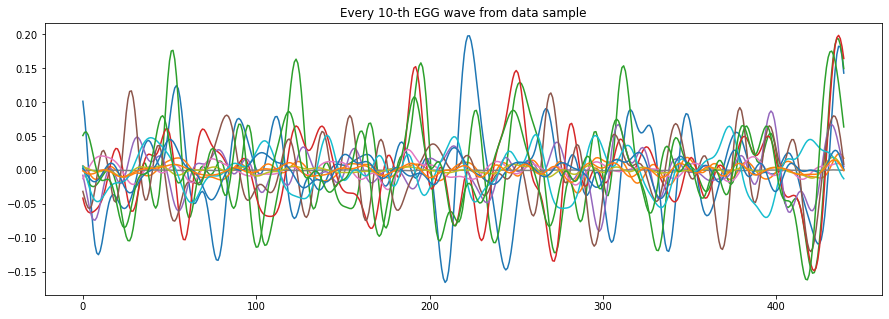

In [10]:
fig, ax = plt.subplots(figsize=(15, 5))
for i in range(egg_sample.shape[1]):
    if i % 10== 0:
        plt.plot(egg_sample[:, i])
plt.title('Every 10-th EGG wave from data sample')        
plt.show()

### Setting up model

In [11]:
# Define model
class Model(nn.Module):

    def __init__(self, input_size, lstm_size, lstm_layers, embedding_size, num_classes):
        # Call parent
        super().__init__()
        # Define parameters
        self.input_size = input_size
        self.lstm_size = lstm_size
        self.lstm_layers = lstm_layers
        self.embedding_size = embedding_size
        self.num_classes = num_classes
        # Define internal modules
        self.lstm = nn.LSTM(input_size, lstm_size, num_layers=lstm_layers, batch_first=True)
        self.embedding = nn.Linear(lstm_size, embedding_size)
        self.classifier = nn.Linear(embedding_size, num_classes)

    def forward(self, x):
        # Prepare LSTM initiale state
        batch_size = x.size(0)
        # Forward LSTM and get final state
        x = self.lstm(x)[0][:,-1,:]
        # Forward embedding
        x = F.relu(self.embedding(x))
        # Forward classifier
        x = self.classifier(x)
        return x

In [13]:
model = Model(128, LSTM_SIZE, LSTM_LAYERS, EMBEDDING_SIZE, NUM_CLASSES)
optimizer = getattr(torch.optim, OPTIM_NAME)(model.parameters(), lr = LR)

In [ ]:
# Setup CUDA
if not NO_CUDA:
    model.cuda()
    print("Copied to CUDA")

# Start training
for epoch in range(1, EPOCHS+1):
    # Initialize loss/accuracy variables
    losses = {"train": 0, "val": 0, "test": 0}
    accuracies = {"train": 0, "val": 0, "test": 0}
    counts = {"train": 0, "val": 0, "test": 0}
    # Adjust learning rate for SGD
    if OPTIM_NAME == "SGD":
        lr = LR * (LR_DECAY_FACTOR ** (epoch // LR_DECAY_PERIOD))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    # Process each split
    for split in ("train", "val", "test"):
        # Set network mode
        if split == "train":
            model.train()
            torch.set_grad_enabled(True)
        else:
            model.eval()
            torch.set_grad_enabled(False)
        # Process all split batches
        for i, (input, target) in enumerate(loaders[split]):
            # Check CUDA
            if not NO_CUDA:
                input = input.cuda(async = True)
                target = target.cuda(async = True)
            # Forward
            output = model(input)
            loss = F.cross_entropy(output, target)
            losses[split] += loss.item()
            # Compute accuracy
            _,pred = output.data.max(1)
            correct = pred.eq(target.data).sum().item()
            accuracy = correct/input.data.size(0)
            accuracies[split] += accuracy
            counts[split] += 1
            # Backward and optimize
            if split == "train":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    # Print info at the end of the epoch
    print("Epoch {0}: TrL={1:.4f}, TrA={2:.4f}, VL={3:.4f}, VA={4:.4f}, TeL={5:.4f}, TeA={6:.4f}".format(epoch,
                                                                                                         losses["train"]/counts["train"],
                                                                                                         accuracies["train"]/counts["train"],
                                                                                                         losses["val"]/counts["val"],
                                                                                                         accuracies["val"]/counts["val"],
                                                                                                         losses["test"]/counts["test"],
                                                                                                         accuracies["test"]/counts["test"]))
